In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import glob
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
from netCDF4 import date2num, num2date
import pandas as pd
import numpy as np
import math
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets_AllVars import *
from DefineModelAttributes import *
from SR_UNet_simple import *
from utils import *

In [2]:
# test_ds_2 = HRRR_URMA_Dataset_AllVars(is_train=True,
#                                       months=[1,12],  
#                                       hours="all", 
#                                       forecast_lead_time=1,
#                                       normalization_scheme = "all times",
#                                       with_terrains=["hrrr","urma","diff"], 
#                                       with_yearly_time_sig=True, 
#                                       with_hourly_time_sig=True,
#                                       time_sig_scheme="Frac",
#                                       predictor_vars = ["t2m", "d2m", "pressurf", "u10m", "v10m"],
#                                       target_vars = ["t2m"])#, "d2m", "pressurf", "u10m", "v10m"])

In [3]:
IDX_MIN_LON=596
IDX_MIN_LAT=645
IMG_SIZE_LON=180
IMG_SIZE_LAT=180

In [4]:
TARG_VAR="pressurf"
test_urma = xr.open_dataarray(f"/data1/projects/RTMA/alex.schein/URMA_train_test/test_urma_alltimes_{TARG_VAR}.nc", decode_timedelta=True)

In [5]:
test_hrrr_attrs = DefineModelAttributes(is_train=False, target_vars=[TARG_VAR])
test_hrrr_attrs.create_dataset()

Terrain normalization done for ['diff']
Loading predictor dataset for t2m (Year = 2024, months = 1 to 12, hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Predictor dataset data loaded. Time taken = 1.8 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for d2m (Year = 2024, months = 1 to 12, hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Predictor dataset data loaded. Time taken = 1.8 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for pressurf (Year = 2024, months = 1 to 12, hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])
Predictor dataset data loaded. Time taken = 1.4 sec
Normalizing over all times
Normalization done. Time taken = 0.5 sec
Loading predictor dataset for u10m (Year = 2024, months = 1 to 12, hours = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,

In [6]:
model = SR_UNet_simple(n_channels_in=test_hrrr_attrs.num_channels_in)
device = torch.device("cuda")
model.to(device)
model.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/CNN_Main/Trained_models/{test_hrrr_attrs.savename}.pt", weights_only=True))

<All keys matched successfully>

In [12]:
test_hrrr_attrs.normalization_scheme == "all times"

True

In [8]:
varname_translation_dict = {"t2m":"t2m",
                            "d2m":"d2m",
                            "pressurf":"sp",
                            "u10m":"u10",
                            "v10m":"v10"}

urma_var_select_dict = {"t2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                        "d2m":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':2}}, 
                        "sp":{'filter_by_keys':{'typeOfLevel': 'surface'}},
                        "u10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}},
                        "v10":{'filter_by_keys':{'typeOfLevel': 'heightAboveGround','level':10}}}

In [9]:
IDX = 10
test_smartinit = xr.open_dataset(f"/scratch/RTMA/alex.schein/Misc_netcdf_grib2_files/hrrr_smartinit_20240101_t{str(IDX).zfill(2)}z_f01.grib2", 
                                 engine="cfgrib", 
                                 backend_kwargs=urma_var_select_dict[varname_translation_dict[TARG_VAR]],
                                 decode_timedelta=True)
test_smartinit_var = test_smartinit[varname_translation_dict[TARG_VAR]]
test_smartinit_var_sp_rest = test_smartinit_var.isel(y=slice(IDX_MIN_LAT, IDX_MIN_LAT+IMG_SIZE_LAT),
                                                      x=slice(IDX_MIN_LON, IDX_MIN_LON+IMG_SIZE_LON))

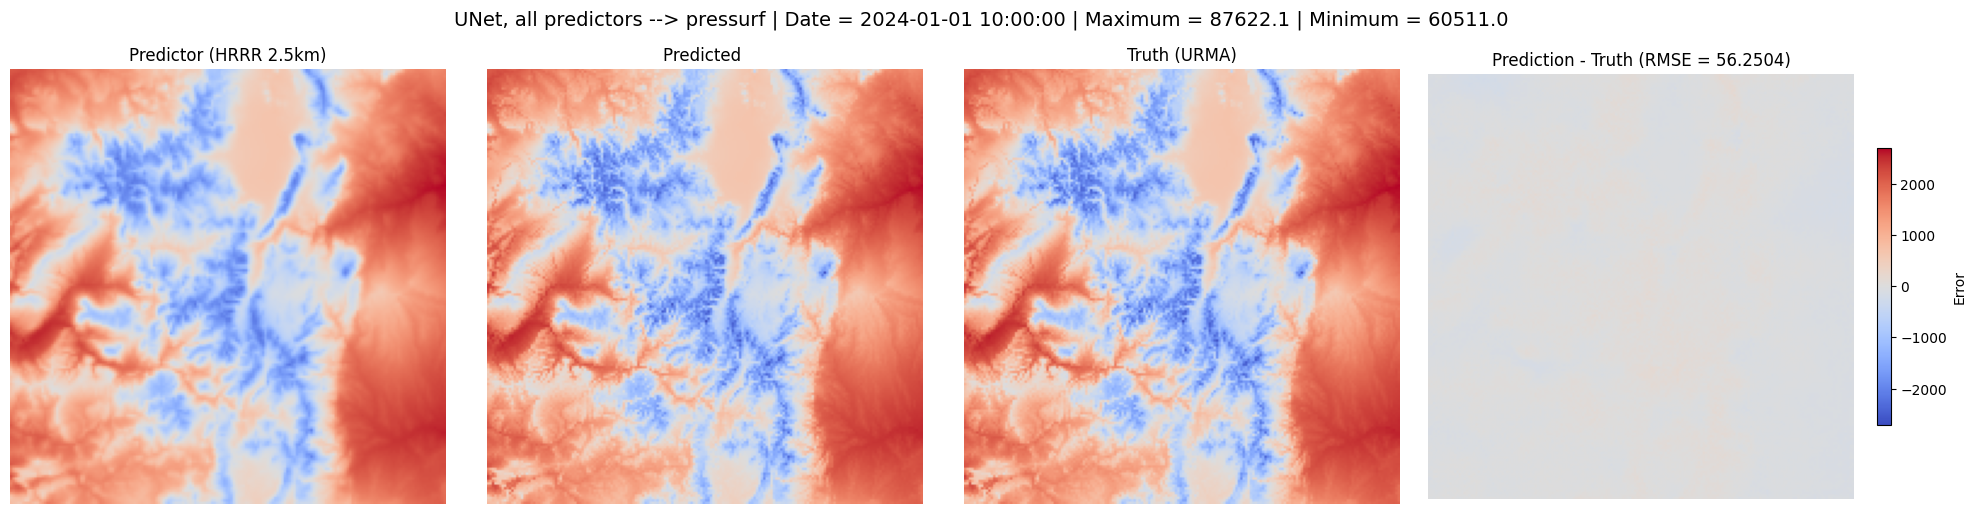

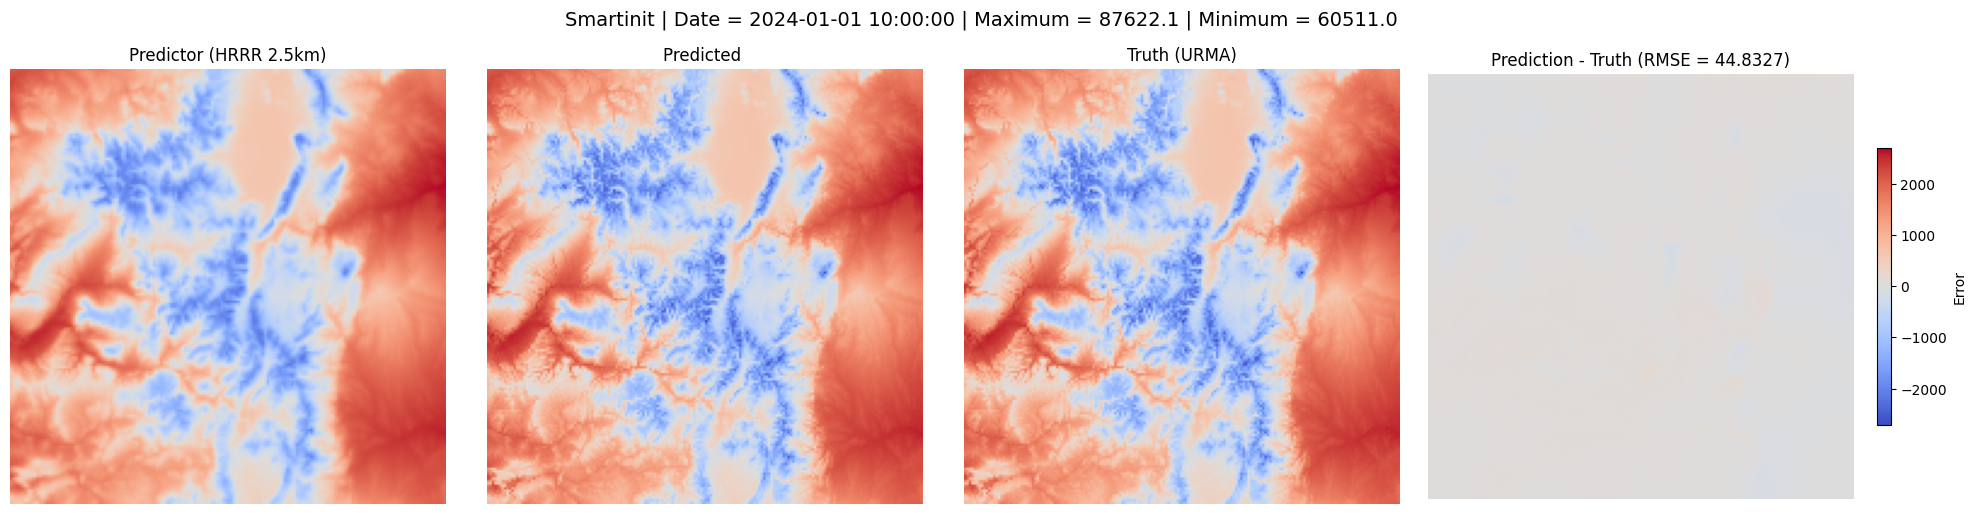

In [10]:
pred, targ, model_output, dt_current = get_model_output_at_idx(model_attrs=test_hrrr_attrs, model=model, idx=IDX, pred_var=TARG_VAR, targ_var=TARG_VAR)
plot_prediction(pred, model_output, targ, date_str=dt_current, savename=f"UNet, all predictors --> {TARG_VAR}")
plot_prediction(pred, test_smartinit_var_sp_rest.data, targ, date_str=dt_current, savename="Smartinit")